# Analysis of mean-FF relationship

In [2]:
import numpy as np
import scipy as sc

import torch
import torch.nn as nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.optim as optim


# add paths to access shared code
import sys
sys.path.append("..")
sys.path.append("../scripts/")

# import library implementing models
import neuroprob as nprb
from neuroprob import utils

# import utility code for model building/training/loading
import lib
import HDC

# get GPU device if available
gpu_dev = 0
dev = utils.pytorch.get_device(gpu=gpu_dev)

# use custom plotting settings
import matplotlib.pyplot as plt

# useful colormap
white = '#ffffff'
red = '#ff0000'
blue = '#0000ff'
weight_map = utils.plot.make_cmap([blue, white, red], 'weight_map')


import warnings
warnings.simplefilter('ignore')


PyTorch version: 1.13.1+cu117
Using device: cuda:0


In [3]:
mice_sessions = {
    'Mouse12': ['120806'],
    'Mouse17': ['130125', '130128', '130131', '130202', '130203'],
    'Mouse20': ['130514', '130515', '130516', '130517'],
    'Mouse24': ['131213', '131217', '131218'],
    'Mouse25': ['140124', '140128', '140129'],
    'Mouse28': ['140310']
} 

phase = 'wake'

bin_size = 160  # ms
single_spikes = False

delay = 0
batch_size = 1000  # size of time segments of each batch in dataset below
cv_run = -1


checkpoint_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/checkpoint/'
data_dir = '/scratches/ramanujan_2/vn283/HDC_PartIII/preprocessed/'

In [4]:
def load_tc_data(datadir, mouse_id, session_id, subset, phase='wake'):
    data = np.load(datadir + f'{mouse_id}_{session_id}_{phase}_{subset}.npz')
    tc_rates = data['tuning_curves_rates']  # (neurons, num_cov, steps)
    tc_FF = data['tuning_curves_FF']  # (neurons, num_cov, steps)
    tc_cov = data['tuning_curves_covariates']  # (num_cov, steps)
    
    return tc_rates, tc_FF, tc_cov

def tuning_index(hd_stat):
    """Compute the tuning index of a tuning curve with a given statistics of spike count distributions."""
    tc_max = np.max(hd_stat, axis=-1)
    tc_min = np.min(hd_stat, axis=-1)

    return (tc_max - tc_min) / (tc_max + tc_min)

In [5]:
tc_datadir = '/scratches/ramanujan_2/vn283/HDC_PartIII/tc_data/'

tuning_curves_rates = np.empty((0, 6, 100))  # we have 6 covariates, so 6 features
tuning_curves_FF = np.empty((0, 6, 100))

label_hdc = np.empty((0,))

for mouse_id in mice_sessions.keys():
    for session_id in mice_sessions[mouse_id]:
        for subset in ['hdc', 'nonhdc']:
            dataset_dict = HDC.get_dataset(mouse_id, session_id, phase, subset, bin_size, 
                                               single_spikes, path=data_dir)
            tc_rates, tc_FF, tc_cov = load_tc_data(tc_datadir, mouse_id, session_id, subset)
            tuning_curves_rates = np.concatenate((tuning_curves_rates, tc_rates), axis=0)
            tuning_curves_FF = np.concatenate((tuning_curves_FF, tc_FF), axis=0)
            
            if subset == 'hdc':
                label_hdc = np.concatenate((label_hdc, np.ones(tc_rates.shape[0])))
            else:
                label_hdc = np.concatenate((label_hdc, np.zeros(tc_rates.shape[0])))


units:  85  hdc units:  22
units:  85  hdc units:  22
units:  21  hdc units:  2
units:  21  hdc units:  2
units:  46  hdc units:  7
units:  46  hdc units:  7
units:  50  hdc units:  7
units:  50  hdc units:  7
units:  55  hdc units:  5
units:  55  hdc units:  5
units:  59  hdc units:  7
units:  59  hdc units:  7
units:  11  hdc units:  2
units:  11  hdc units:  2
units:  13  hdc units:  4
units:  13  hdc units:  4
units:  17  hdc units:  4
units:  17  hdc units:  4
units:  22  hdc units:  6
units:  22  hdc units:  6
units:  28  hdc units:  5
units:  28  hdc units:  5
units:  40  hdc units:  11
units:  40  hdc units:  11
units:  43  hdc units:  11
units:  43  hdc units:  11
units:  36  hdc units:  10
units:  36  hdc units:  10
units:  32  hdc units:  5
units:  32  hdc units:  5
units:  33  hdc units:  11
units:  33  hdc units:  11
units:  56  hdc units:  14
units:  56  hdc units:  14


### Plot rate and Fano Factor

Text(0, 0.5, 'Fano Factor')

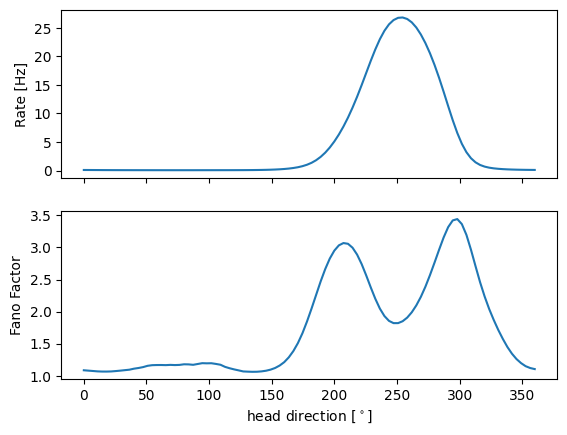

In [8]:
ne=4
fig, ax = plt.subplots(2, 1, sharex=True)

angles = np.linspace(0, 360, tuning_curves_rates.shape[-1])

ax[0].plot(angles, tuning_curves_rates[ne,0,:])
ax[0].set_ylabel('Rate [Hz]')
ax[1].plot(angles, tuning_curves_FF[ne,0,:])
ax[1].set_xlabel('head direction [$^\circ$]')
ax[1].set_ylabel('Fano Factor')

### Comparing the gradient

Text(0, 0.5, 'Fano Factor')

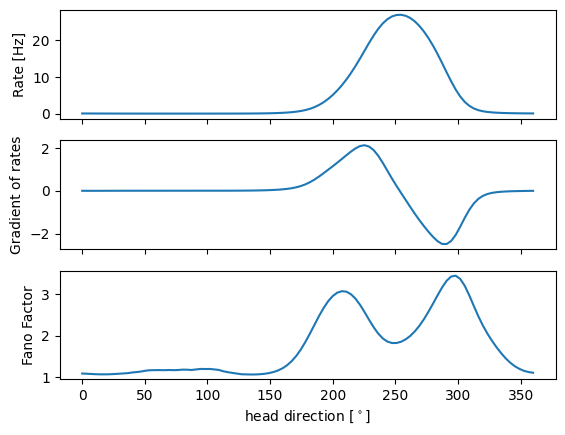

In [9]:
gradient = np.gradient(tuning_curves_rates[ne,0,:])
fig, ax = plt.subplots(3, 1, sharex=True)

angles = np.linspace(0, 360, tuning_curves_rates.shape[-1])

ax[0].plot(angles, tuning_curves_rates[ne,0,:])
ax[0].set_ylabel('Rate [Hz]')
ax[1].plot(angles, gradient)
ax[1].set_ylabel('Gradient of rates')
ax[2].plot(angles, tuning_curves_FF[ne,0,:])
ax[2].set_xlabel('head direction [$^\circ$]')
ax[2].set_ylabel('Fano Factor')

### Compare rate gradient to Fano Factor

In [11]:
correlations = np.empty((0,))

for ne in range(label_hdc.shape[0]):
    C = np.corrcoef(tuning_curves_rates[ne,0,:], tuning_curves_FF[ne,0,:])
    correlations = np.append(correlations, C[0,1])

Text(0, 0.5, 'number of neurons')

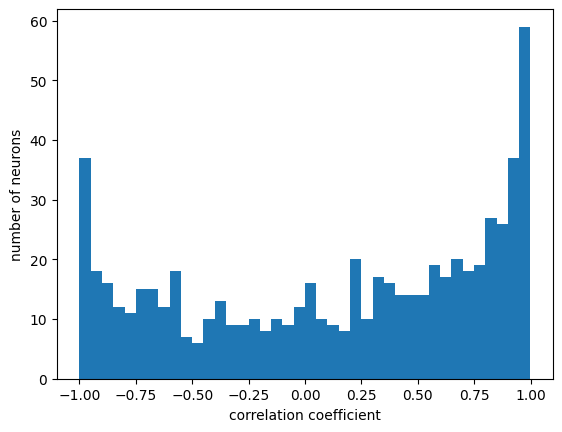

In [12]:
fig, ax = plt.subplots()
ax.hist(correlations, bins=40)
ax.set_xlabel('correlation coefficient')
ax.set_ylabel('number of neurons')

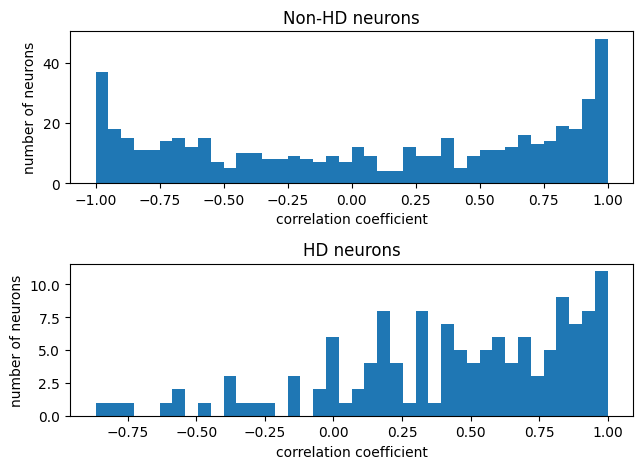

In [25]:
fig, ax = plt.subplots(2, 1)
ax[0].hist(correlations[np.invert(label_hdc.astype(bool))], bins=40)
ax[0].set_xlabel('correlation coefficient')
ax[0].set_ylabel('number of neurons')
ax[0].set_title('Non-HD neurons')
ax[1].hist(correlations[label_hdc.astype(bool)], bins=40)
ax[1].set_xlabel('correlation coefficient')
ax[1].set_ylabel('number of neurons')
ax[1].set_title('HD neurons')

plt.tight_layout()

### Gradient squared

In [26]:
correlations = np.empty((0,))

for ne in range(label_hdc.shape[0]):
    C = np.corrcoef(np.gradient(tuning_curves_rates[ne,0,:])**2, tuning_curves_FF[ne,0,:])
    correlations = np.append(correlations, C[0,1])

Text(0, 0.5, 'number of neurons')

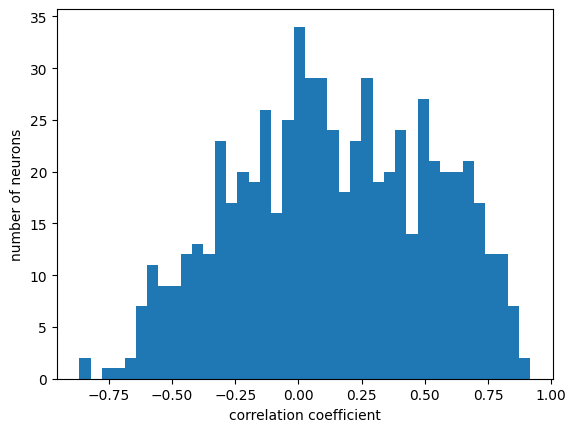

In [27]:
fig, ax = plt.subplots()
ax.hist(correlations, bins=40)
ax.set_xlabel('correlation coefficient')
ax.set_ylabel('number of neurons')

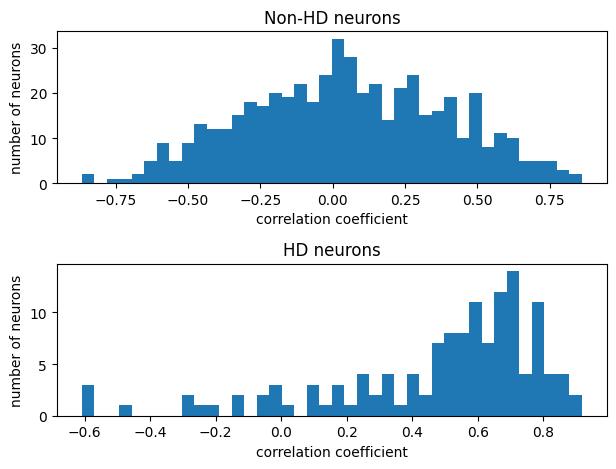

In [28]:
fig, ax = plt.subplots(2, 1)
ax[0].hist(correlations[np.invert(label_hdc.astype(bool))], bins=40)
ax[0].set_xlabel('correlation coefficient')
ax[0].set_ylabel('number of neurons')
ax[0].set_title('Non-HD neurons')
ax[1].hist(correlations[label_hdc.astype(bool)], bins=40)
ax[1].set_xlabel('correlation coefficient')
ax[1].set_ylabel('number of neurons')
ax[1].set_title('HD neurons')

plt.tight_layout()